# Feature engineering - continued

## Load data
We are using the breast cancer dataset.  It has 30 features that are used to help 
determine whether a case is positive.


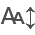

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [21]:
import pandas as pd
from IPython.display import display, HTML
from sklearn.datasets import load_breast_cancer
from typing import Dict, Any, Sequence, Tuple
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

def display_df(df:pd.DataFrame, rows:int=1):
    """ Pretty displays a dataframe with specified rows """
    display(HTML(df.head(rows).to_html()))
    
def concentric_cirle_points(
        coordinate_count:int, 
        r1:float=1.0, 
        r2:float=1.0
):
    """ 
        Generates points on two concentric circles, defined by r1 
        and r2.  The points generated will alternate between the two 
        circles. Point order is clockwise, irrespective of which 
        circle they are on.  
    """
    section_degrees = 360.0/coordinate_count
    for c in range(coordinate_count):
        angle = c * section_degrees
        radians = angle / 180.0 * math.pi
        # sin(ō) = opp/hyp, cos(ō) = adc/hyp
        hypotenus = r1 if c % 2 == 0 else r2
        x = math.sin(radians) * hypotenus
        y = math.cos(radians) * hypotenus
        yield(round(x, 4), round(y, 4))

# Load the Breast Cancer dataset
bc_data = load_breast_cancer()

# Setup vars for values to be used throughout
X, y = bc_data.data, bc_data.target
all_feature_names = bc_data.feature_names
print(bc_data.DESCR)

## Feature selection
Select the most influential features on a positive diagnosis

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier to extract feature importance:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)
importance = clf.feature_importances_

# Setup feature importance dict; ordered by highest importance: 
sorted_indices = importance.argsort()[::-1]
feature_importance = { 
    all_feature_names[i]: importance[i] for i in sorted_indices 
}

for k, v in feature_importance.items():
    print(f"Feature: {k}, Importance: {v:.4f}")

Feature: worst area, Importance: 0.1394
Feature: worst concave points, Importance: 0.1322
Feature: mean concave points, Importance: 0.1070
Feature: worst radius, Importance: 0.0828
Feature: worst perimeter, Importance: 0.0808
Feature: mean perimeter, Importance: 0.0680
Feature: mean concavity, Importance: 0.0669
Feature: mean area, Importance: 0.0605
Feature: worst concavity, Importance: 0.0373
Feature: mean radius, Importance: 0.0348
Feature: area error, Importance: 0.0296
Feature: worst compactness, Importance: 0.0199
Feature: worst texture, Importance: 0.0175
Feature: mean texture, Importance: 0.0152
Feature: radius error, Importance: 0.0143
Feature: worst smoothness, Importance: 0.0122
Feature: mean compactness, Importance: 0.0116
Feature: perimeter error, Importance: 0.0101
Feature: worst symmetry, Importance: 0.0082
Feature: mean smoothness, Importance: 0.0080
Feature: fractal dimension error, Importance: 0.0059
Feature: concavity error, Importance: 0.0058
Feature: compactness er

## Explore the dataset with pandas

In [23]:
bc_df = load_breast_cancer(as_frame=True)
df = bc_df.frame

# Add column for target (i.e., expected output):
df['target'] = bc_data.target


# Explore the dataset
print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns)
print("Target distribution:")
print(df['target'].value_counts())

# Statistical summary
print("\nStatistical summary:")
display_df(df.describe(), 30)

# Correlation analysis
print("\nCorrelation matrix:")
corr_matrix = df.corr()
display_df(corr_matrix, 30)

Dataset shape: (569, 31)
Dataset columns: Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')
Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Statistical summary:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000



Correlation matrix:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


## Show a scatter plot between two of our most indicative features:

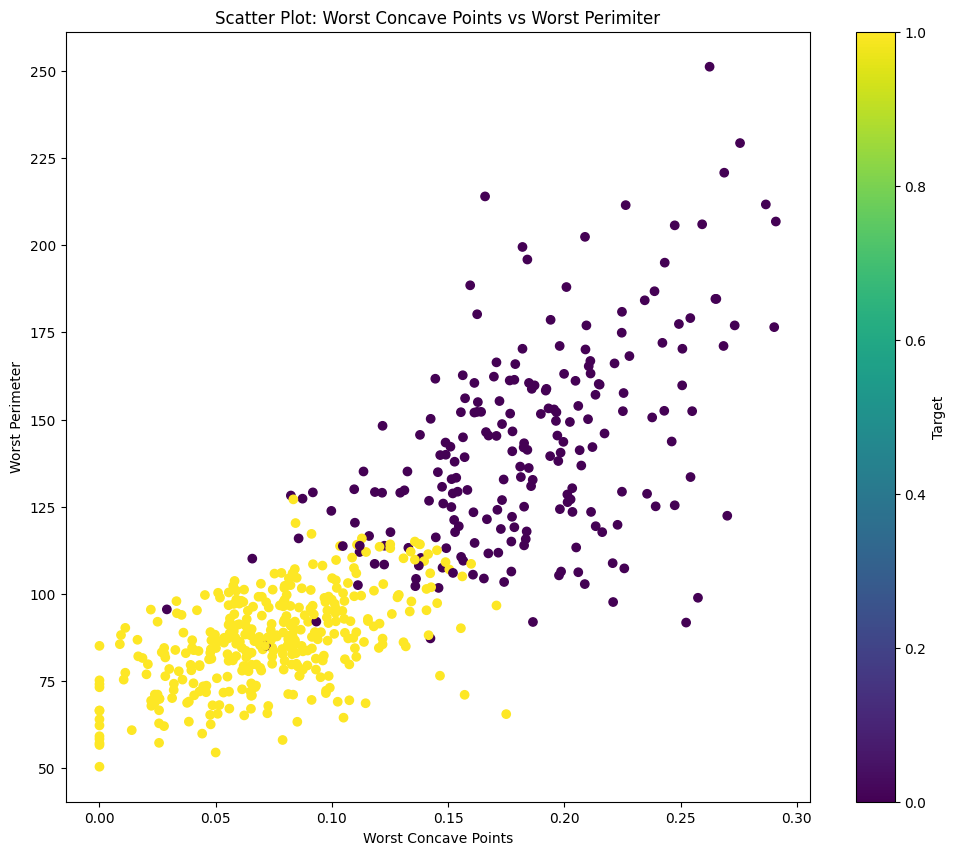

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.scatter(
    df['worst concave points'], 
    df['worst perimeter'], 
    c=df['target'], 
    cmap='viridis'
)
plt.xlabel('Worst Concave Points')
plt.ylabel('Worst Perimeter')
plt.title('Scatter Plot: Worst Concave Points vs Worst Perimiter')
plt.colorbar(label='Target')
plt.show()

## Build graphs

In [25]:
import math
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a graph
G = nx.DiGraph()

# Normalize importances from 0.0-1.0
max_val = max(feature_importance.values())
norm_importance = {k:(f/max_val) for k, f in feature_importance.items()}

# Add node for diagnosis:
DIAGNOSIS_LABEL = "PositiveDiagnosis"
G.add_node(DIAGNOSIS_LABEL, type="diagnosis")

# Add nodes/edges for features
for feature in all_feature_names:
    G.add_node(feature, type="feature", importance=feature_importance[feature])
    G.add_edge(feature, DIAGNOSIS_LABEL, weight=norm_importance[feature], label=f"{feature_importance[feature]:.2f}")

## Visualize the graph

### Get Node Positions
Get positions for nodes. For this example, we'd like to build a concentric circle of Feature nodes, in order of highest importance, surrounding the Diagnosis Node

In [30]:
# Constants to control concentric circle generation:
NODE_INCR = 200
LABEL_INCR = 100
R1=1000
R2=R1 + NODE_INCR
R3=R2 + LABEL_INCR
R4=R3 + NODE_INCR

# Get concentric circles coordinates for nodes:
feature_cnt = len(feature_importance)
node_pts = concentric_cirle_points(feature_cnt, r1=R1, r2=R2)

coords = list(node_pts)
node_positions = { 
    feature_name: coords[i] for i, feature_name 
         in enumerate(feature_importance.keys()) 
}
node_positions[DIAGNOSIS_LABEL] = (0.0, 0.0)

# Get concentric circles coordinates for labels, 
# just (slightly further out than the nodes):
lbl_pts = concentric_cirle_points(feature_cnt, r1=R3, r2=R4)
label_coords = list(lbl_pts)                                    
label_positions = { 
    feature_name: label_coords[i] for i, feature_name 
        in enumerate(feature_importance.keys()) 
}
label_positions[DIAGNOSIS_LABEL] = (0.0, 0.0)

### Use matplotlib to render our networkx graph

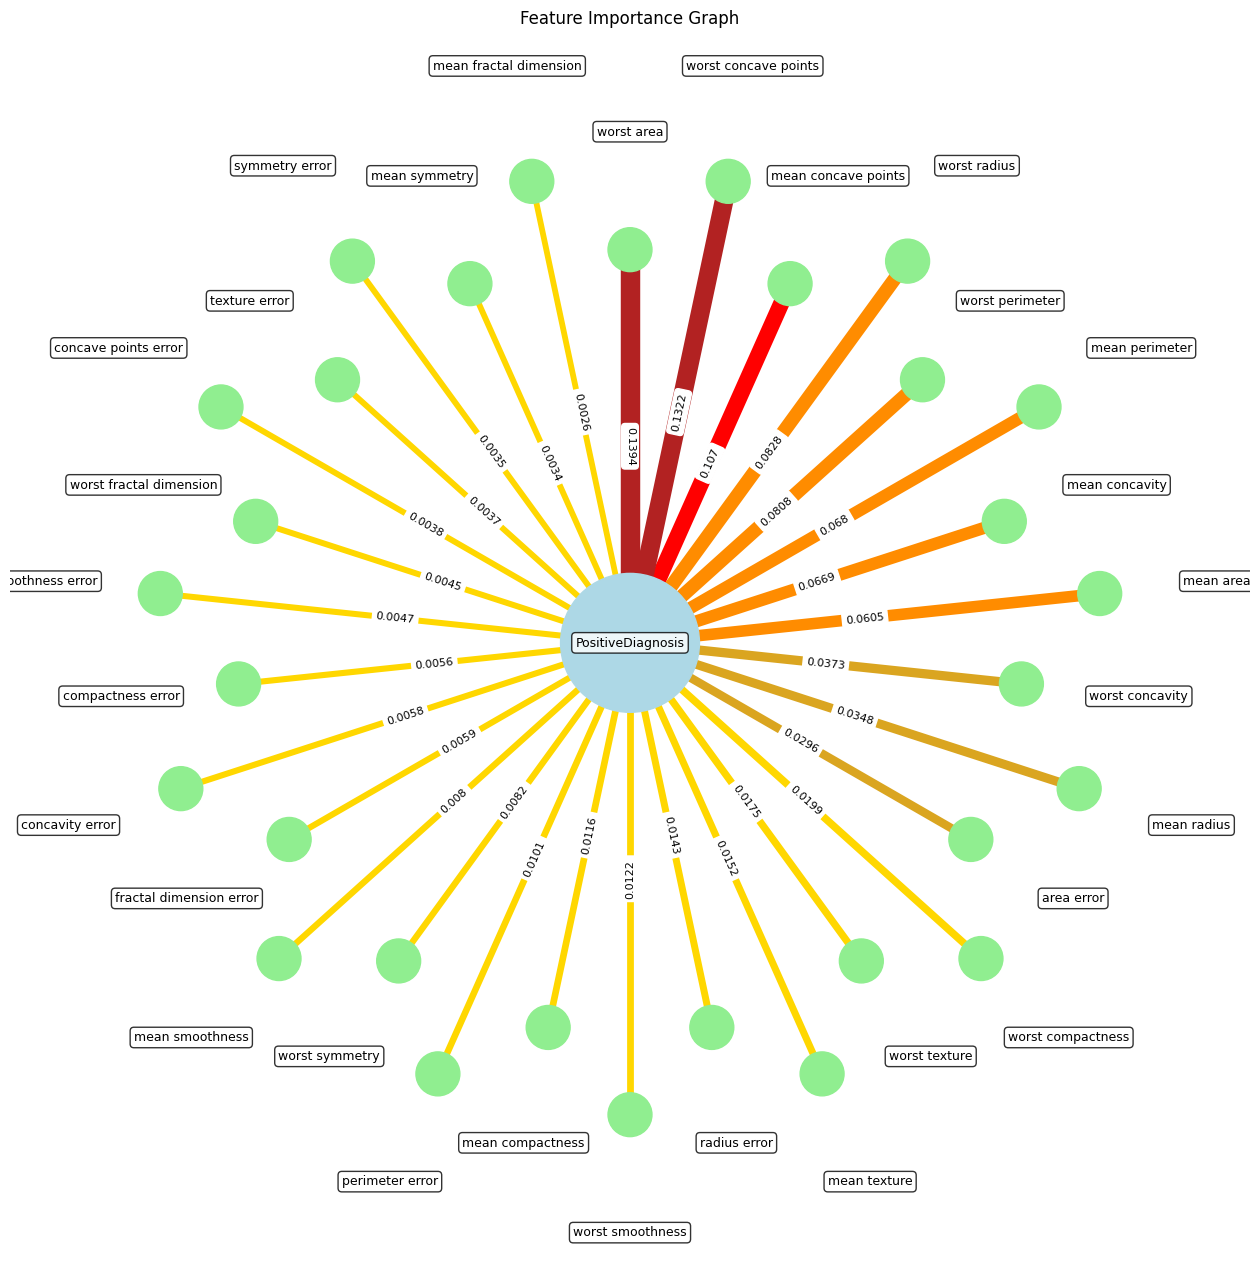

Feature: worst area, Importance: 0.1394
Feature: worst concave points, Importance: 0.1322
Feature: mean concave points, Importance: 0.1070
Feature: worst radius, Importance: 0.0828
Feature: worst perimeter, Importance: 0.0808
Feature: mean perimeter, Importance: 0.0680
Feature: mean concavity, Importance: 0.0669
Feature: mean area, Importance: 0.0605
Feature: worst concavity, Importance: 0.0373
Feature: mean radius, Importance: 0.0348
Feature: area error, Importance: 0.0296
Feature: worst compactness, Importance: 0.0199
Feature: worst texture, Importance: 0.0175
Feature: mean texture, Importance: 0.0152
Feature: radius error, Importance: 0.0143
Feature: worst smoothness, Importance: 0.0122
Feature: mean compactness, Importance: 0.0116
Feature: perimeter error, Importance: 0.0101
Feature: worst symmetry, Importance: 0.0082
Feature: mean smoothness, Importance: 0.0080
Feature: fractal dimension error, Importance: 0.0059
Feature: concavity error, Importance: 0.0058
Feature: compactness er

In [31]:
# Constants needed to control NODE & EDGE sizes:
NODE_SIZE = 1000
BOSS_NODE_SIZE = 10000
EDGE_SCALE = 10.0
EDGE_MIN = 4.0

# Clreate matplotlib plot on which to draw our graph:
plt.figure(figsize=(16, 16))

# Edge colors are a factor of normalized importance, 
# and use interpolated colors from colormap:
edge_colors = [norm_importance[e[0]] for e in G.edges]
edge_widths = [
   EDGE_MIN + G.edges[e]["weight"] * EDGE_SCALE for e in G.edges
]

# Node colors are lightgreen or lightblue:
node_colors = ["lightgreen" 
    if ("type" in G.nodes[n] and G.nodes[n]["type"] == "feature") 
    else "lightblue" for n in G.nodes
]

# Node sizes are NODE_SIZE or BOSS_NODE_SIZE:
node_sizes  = [NODE_SIZE 
    if G.nodes[n]["type"] == "feature" 
    else BOSS_NODE_SIZE for n in G.nodes
]

# Create edge labels based on feature importance:
edge_labels = {e: round(feature_importance[e[0]], 4) 
    for e in G.edges
}

# Create colormap for edges to interpolate between, based on normalized importance values:
edge_colormap = ListedColormap([
    'gold', 
    'goldenrod', 
    'darkorange', 
    'red', 
    'firebrick']).resampled(1024)

# Draw network without labels:
nx.draw_networkx(
    G, 
    node_positions, 
    alpha=1.0, 
    arrows=False, 
    edge_color=edge_colors, 
    edge_cmap=edge_colormap,
    edge_vmax=1.0, 
    edge_vmin=0.0, 
    label="Features most relevant to positive diagnosis",     
    margins=0.002, 
    node_color=node_colors, 
    node_size=node_sizes,     
    with_labels=False, 
    width=edge_widths,     
)

# Draw labels at offset positions:
nx.draw_networkx_labels(
    G, 
    label_positions, 
    font_size=9, 
    bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
)

# Draw edge labels:
nx.draw_networkx_edge_labels(
    G, 
    node_positions, 
    edge_labels=edge_labels, 
    font_size=8
)

# Render with matplotlib:
plt.margins(x=0.1, y=0.1)
plt.axis("off")
plt.title("Feature Importance Graph")
plt.show()

# Print feature importances
for k, v in feature_importance.items():
    print(f"Feature: {k}, Importance: {v:.4f}")